# Decision Trees: Theory and Implementation

## Introduction

Decision trees are fundamental supervised learning algorithms used for both classification and regression tasks. They partition the feature space into rectangular regions through a series of binary splits, creating an interpretable hierarchical structure that mimics human decision-making.

## Theoretical Foundation

### The Decision Tree Model

A decision tree recursively partitions the input space $\mathcal{X} \subseteq \mathbb{R}^d$ into disjoint regions $\{R_1, R_2, \ldots, R_M\}$. For each region $R_m$, we assign a prediction:

$$\hat{y}(\mathbf{x}) = \sum_{m=1}^{M} c_m \cdot \mathbb{1}(\mathbf{x} \in R_m)$$

where $c_m$ is the prediction for region $R_m$ and $\mathbb{1}(\cdot)$ is the indicator function.

### Splitting Criteria

#### Information Gain and Entropy

For classification, we use **entropy** to measure impurity. The entropy of a node $t$ with class distribution $(p_1, p_2, \ldots, p_K)$ is:

$$H(t) = -\sum_{k=1}^{K} p_k \log_2(p_k)$$

The **information gain** from a split using feature $j$ at threshold $\theta$ is:

$$\text{IG}(t, j, \theta) = H(t) - \frac{|t_L|}{|t|} H(t_L) - \frac{|t_R|}{|t|} H(t_R)$$

where $t_L$ and $t_R$ are the left and right child nodes.

#### Gini Impurity

An alternative measure is the **Gini impurity**:

$$G(t) = 1 - \sum_{k=1}^{K} p_k^2 = \sum_{k=1}^{K} p_k(1 - p_k)$$

The Gini impurity reaches its minimum (0) when all samples belong to a single class and maximum when samples are uniformly distributed.

### Tree Construction Algorithm

The CART (Classification and Regression Trees) algorithm uses a greedy approach:

1. At each node $t$, find the optimal split $(j^*, \theta^*)$:
   $$j^*, \theta^* = \arg\min_{j, \theta} \left[ \frac{|t_L|}{|t|} \text{Impurity}(t_L) + \frac{|t_R|}{|t|} \text{Impurity}(t_R) \right]$$

2. Create child nodes and recurse

3. Stop when a termination criterion is met (max depth, min samples, pure node)

### Complexity Analysis

For $n$ samples and $d$ features:
- Building: $O(d \cdot n \log n)$ per node (sorting)
- Total: $O(d \cdot n^2 \log n)$ worst case
- Prediction: $O(\log n)$ average, $O(n)$ worst case

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Set random seed for reproducibility
np.random.seed(42)

## Implementation from Scratch

We implement a decision tree classifier using Gini impurity as the splitting criterion.

In [2]:
class Node:
    """A node in the decision tree."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # Index of feature to split on
        self.threshold = threshold  # Threshold value for split
        self.left = left           # Left subtree
        self.right = right         # Right subtree
        self.value = value         # Prediction value (for leaf nodes)

class DecisionTreeClassifier:
    """Decision Tree Classifier using Gini impurity."""
    
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    def _gini(self, y):
        """Calculate Gini impurity: G = 1 - Σ p_k²"""
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _entropy(self, y):
        """Calculate entropy: H = -Σ p_k log₂(p_k)"""
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / len(y)
        probabilities = probabilities[probabilities > 0]
        return -np.sum(probabilities * np.log2(probabilities))
    
    def _best_split(self, X, y):
        """Find the best split for a node using Gini impurity."""
        n_samples, n_features = X.shape
        
        if n_samples < self.min_samples_split:
            return None, None
        
        # Current impurity
        current_gini = self._gini(y)
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        for feature in range(n_features):
            # Get unique values for thresholds
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Split the data
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                # Calculate weighted Gini impurity after split
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                
                gini_left = self._gini(y[left_mask])
                gini_right = self._gini(y[right_mask])
                
                weighted_gini = (n_left * gini_left + n_right * gini_right) / n_samples
                gain = current_gini - weighted_gini
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree."""
        n_samples = len(y)
        n_classes = len(np.unique(y))
        
        # Stopping criteria
        if depth >= self.max_depth or n_classes == 1 or n_samples < self.min_samples_split:
            # Return leaf node with majority class
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Find best split
        best_feature, best_threshold = self._best_split(X, y)
        
        if best_feature is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)
        
        # Create child nodes
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold,
                   left=left_subtree, right=right_subtree)
    
    def fit(self, X, y):
        """Fit the decision tree to training data."""
        self.n_classes = len(np.unique(y))
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_single(self, x, node):
        """Predict class for a single sample."""
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)
    
    def predict(self, X):
        """Predict classes for all samples."""
        return np.array([self._predict_single(x, self.root) for x in X])
    
    def score(self, X, y):
        """Calculate accuracy score."""
        predictions = self.predict(X)
        return np.mean(predictions == y)

## Data Generation

We create a synthetic dataset with two features and three classes arranged in a pattern that demonstrates the axis-aligned decision boundaries of decision trees.

In [3]:
def generate_multiclass_data(n_samples=300):
    """Generate synthetic data with three classes."""
    n_per_class = n_samples // 3
    
    # Class 0: Lower left region
    X0 = np.random.randn(n_per_class, 2) * 0.8 + np.array([-2, -2])
    y0 = np.zeros(n_per_class, dtype=int)
    
    # Class 1: Upper right region
    X1 = np.random.randn(n_per_class, 2) * 0.8 + np.array([2, 2])
    y1 = np.ones(n_per_class, dtype=int)
    
    # Class 2: Middle region (more challenging)
    X2 = np.random.randn(n_per_class, 2) * 1.0 + np.array([0, 0])
    y2 = np.full(n_per_class, 2, dtype=int)
    
    X = np.vstack([X0, X1, X2])
    y = np.concatenate([y0, y1, y2])
    
    # Shuffle the data
    shuffle_idx = np.random.permutation(len(y))
    return X[shuffle_idx], y[shuffle_idx]

# Generate data
X, y = generate_multiclass_data(n_samples=300)

# Split into train and test sets
n_train = int(0.8 * len(y))
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")
print(f"Class distribution (train): {dict(Counter(y_train))}")

Training samples: 240
Test samples: 60
Class distribution (train): {np.int64(0): 83, np.int64(2): 82, np.int64(1): 75}


## Model Training and Evaluation

In [4]:
# Train the decision tree
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=5)
tree.fit(X_train, y_train)

# Evaluate
train_accuracy = tree.score(X_train, y_train)
test_accuracy = tree.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9583
Test Accuracy: 0.9000


## Visualization of Decision Boundaries

We visualize the decision boundaries created by the tree, demonstrating the characteristic axis-aligned rectangular regions.

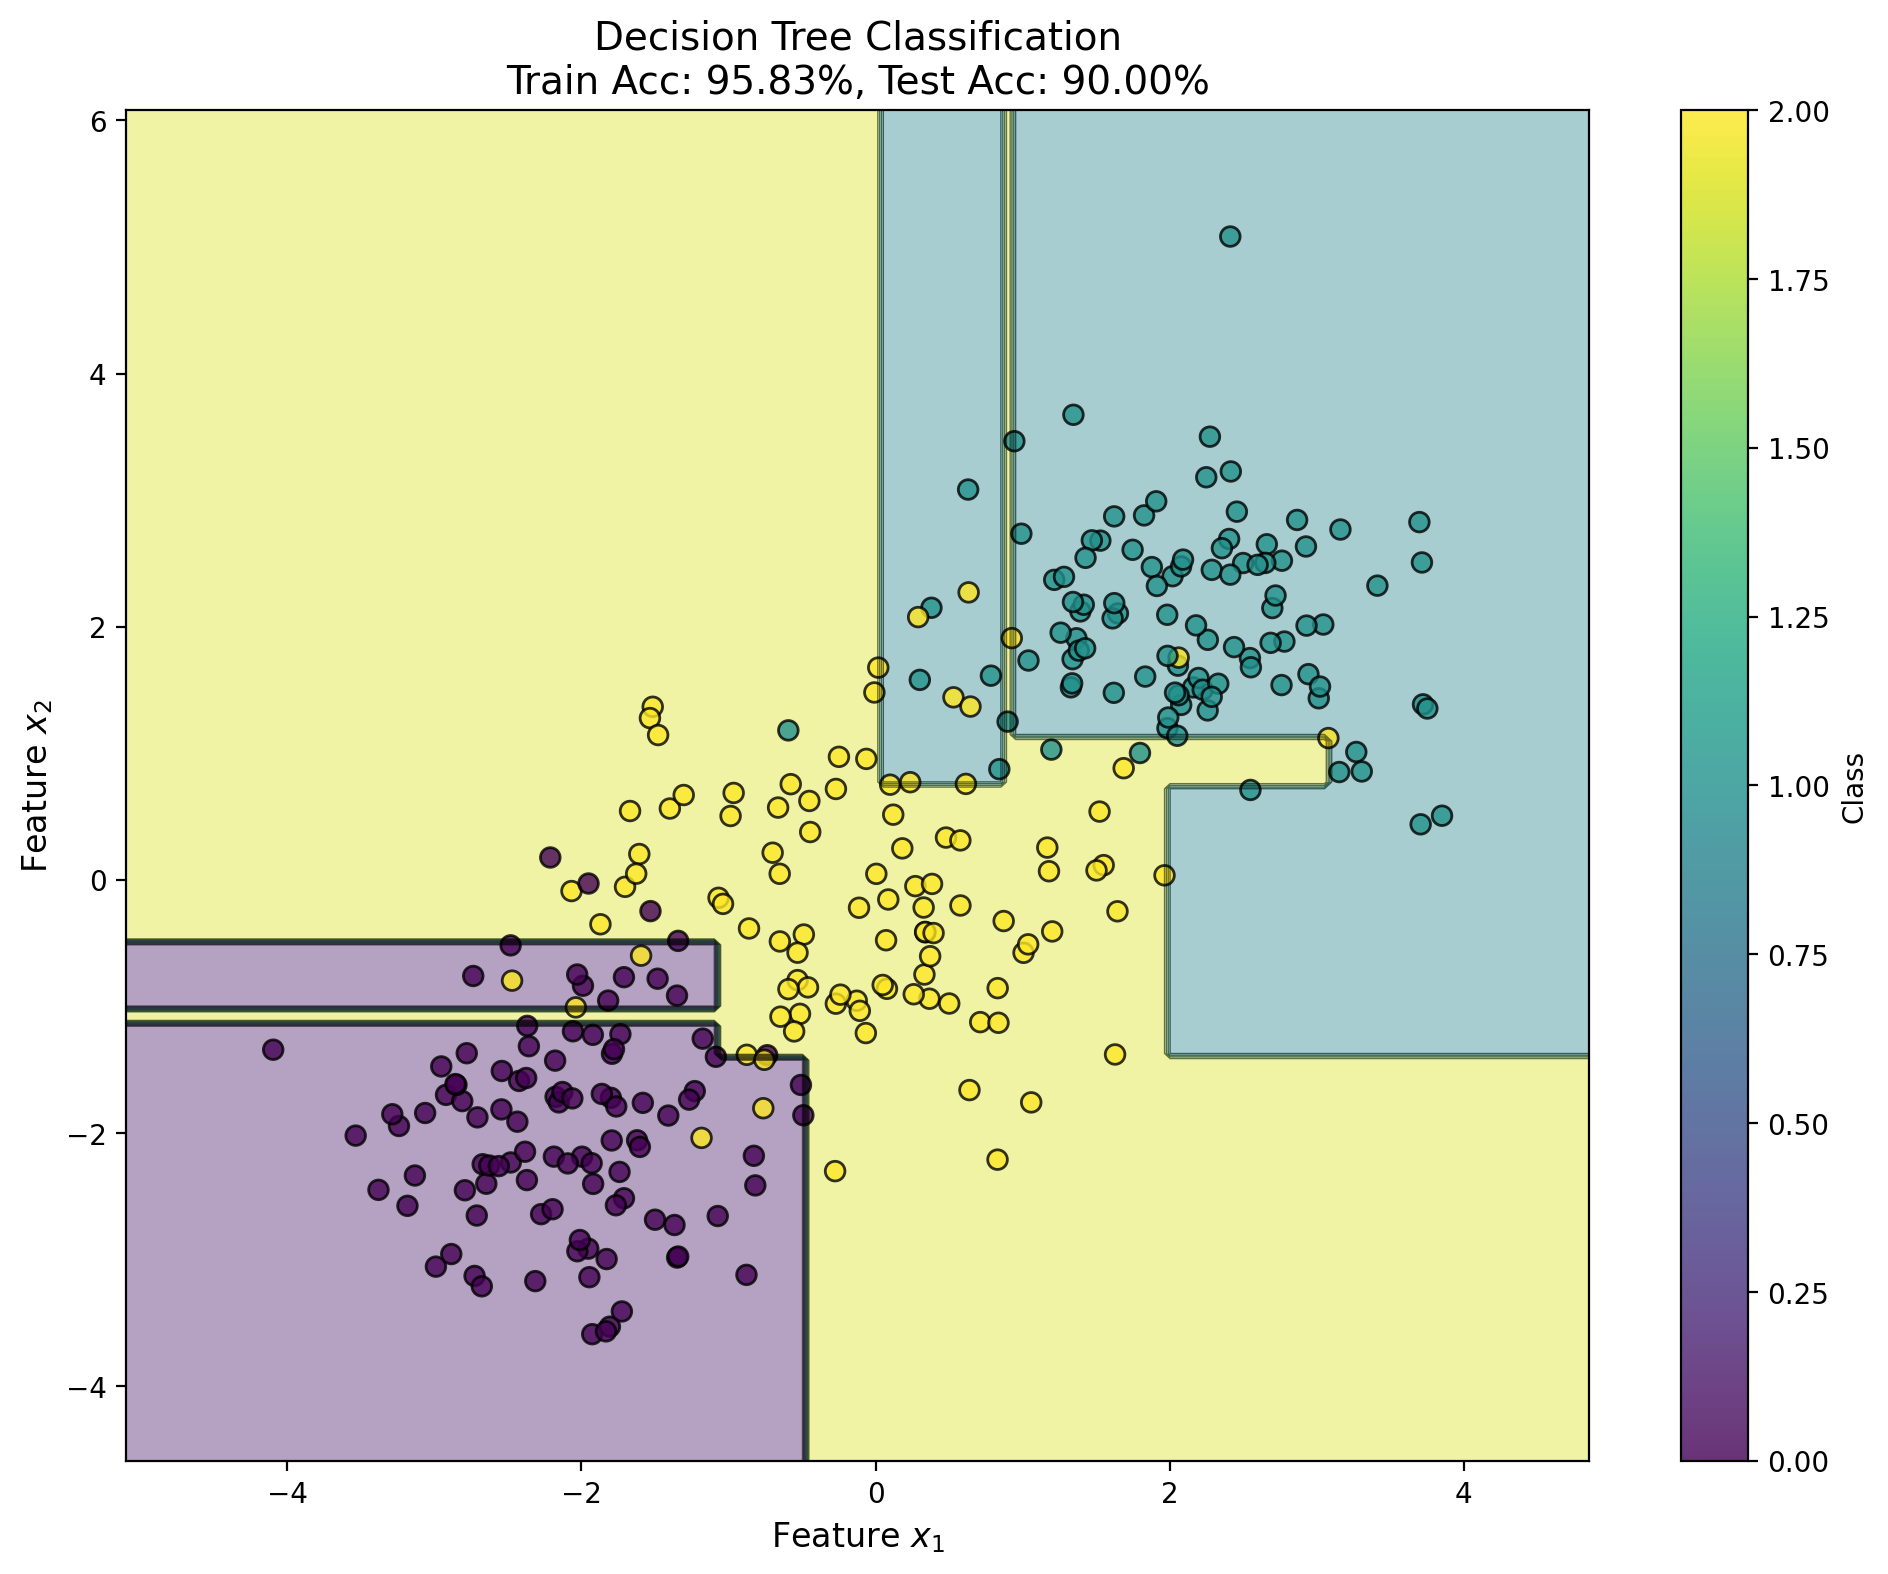

In [5]:
def plot_decision_boundary(model, X, y, title="Decision Tree Boundaries"):
    """Plot decision boundaries and data points."""
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Decision regions
    contour = ax.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    ax.contour(xx, yy, Z, colors='k', linewidths=0.5, alpha=0.5)
    
    # Data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
                        edgecolors='black', s=50, alpha=0.8)
    
    ax.set_xlabel('Feature $x_1$', fontsize=12)
    ax.set_ylabel('Feature $x_2$', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Class', fontsize=10)
    
    return fig, ax

fig, ax = plot_decision_boundary(tree, X, y, 
    f"Decision Tree Classification\nTrain Acc: {train_accuracy:.2%}, Test Acc: {test_accuracy:.2%}")
plt.tight_layout()

## Analysis: Effect of Tree Depth

We examine how tree depth affects the bias-variance tradeoff by training trees with different maximum depths.

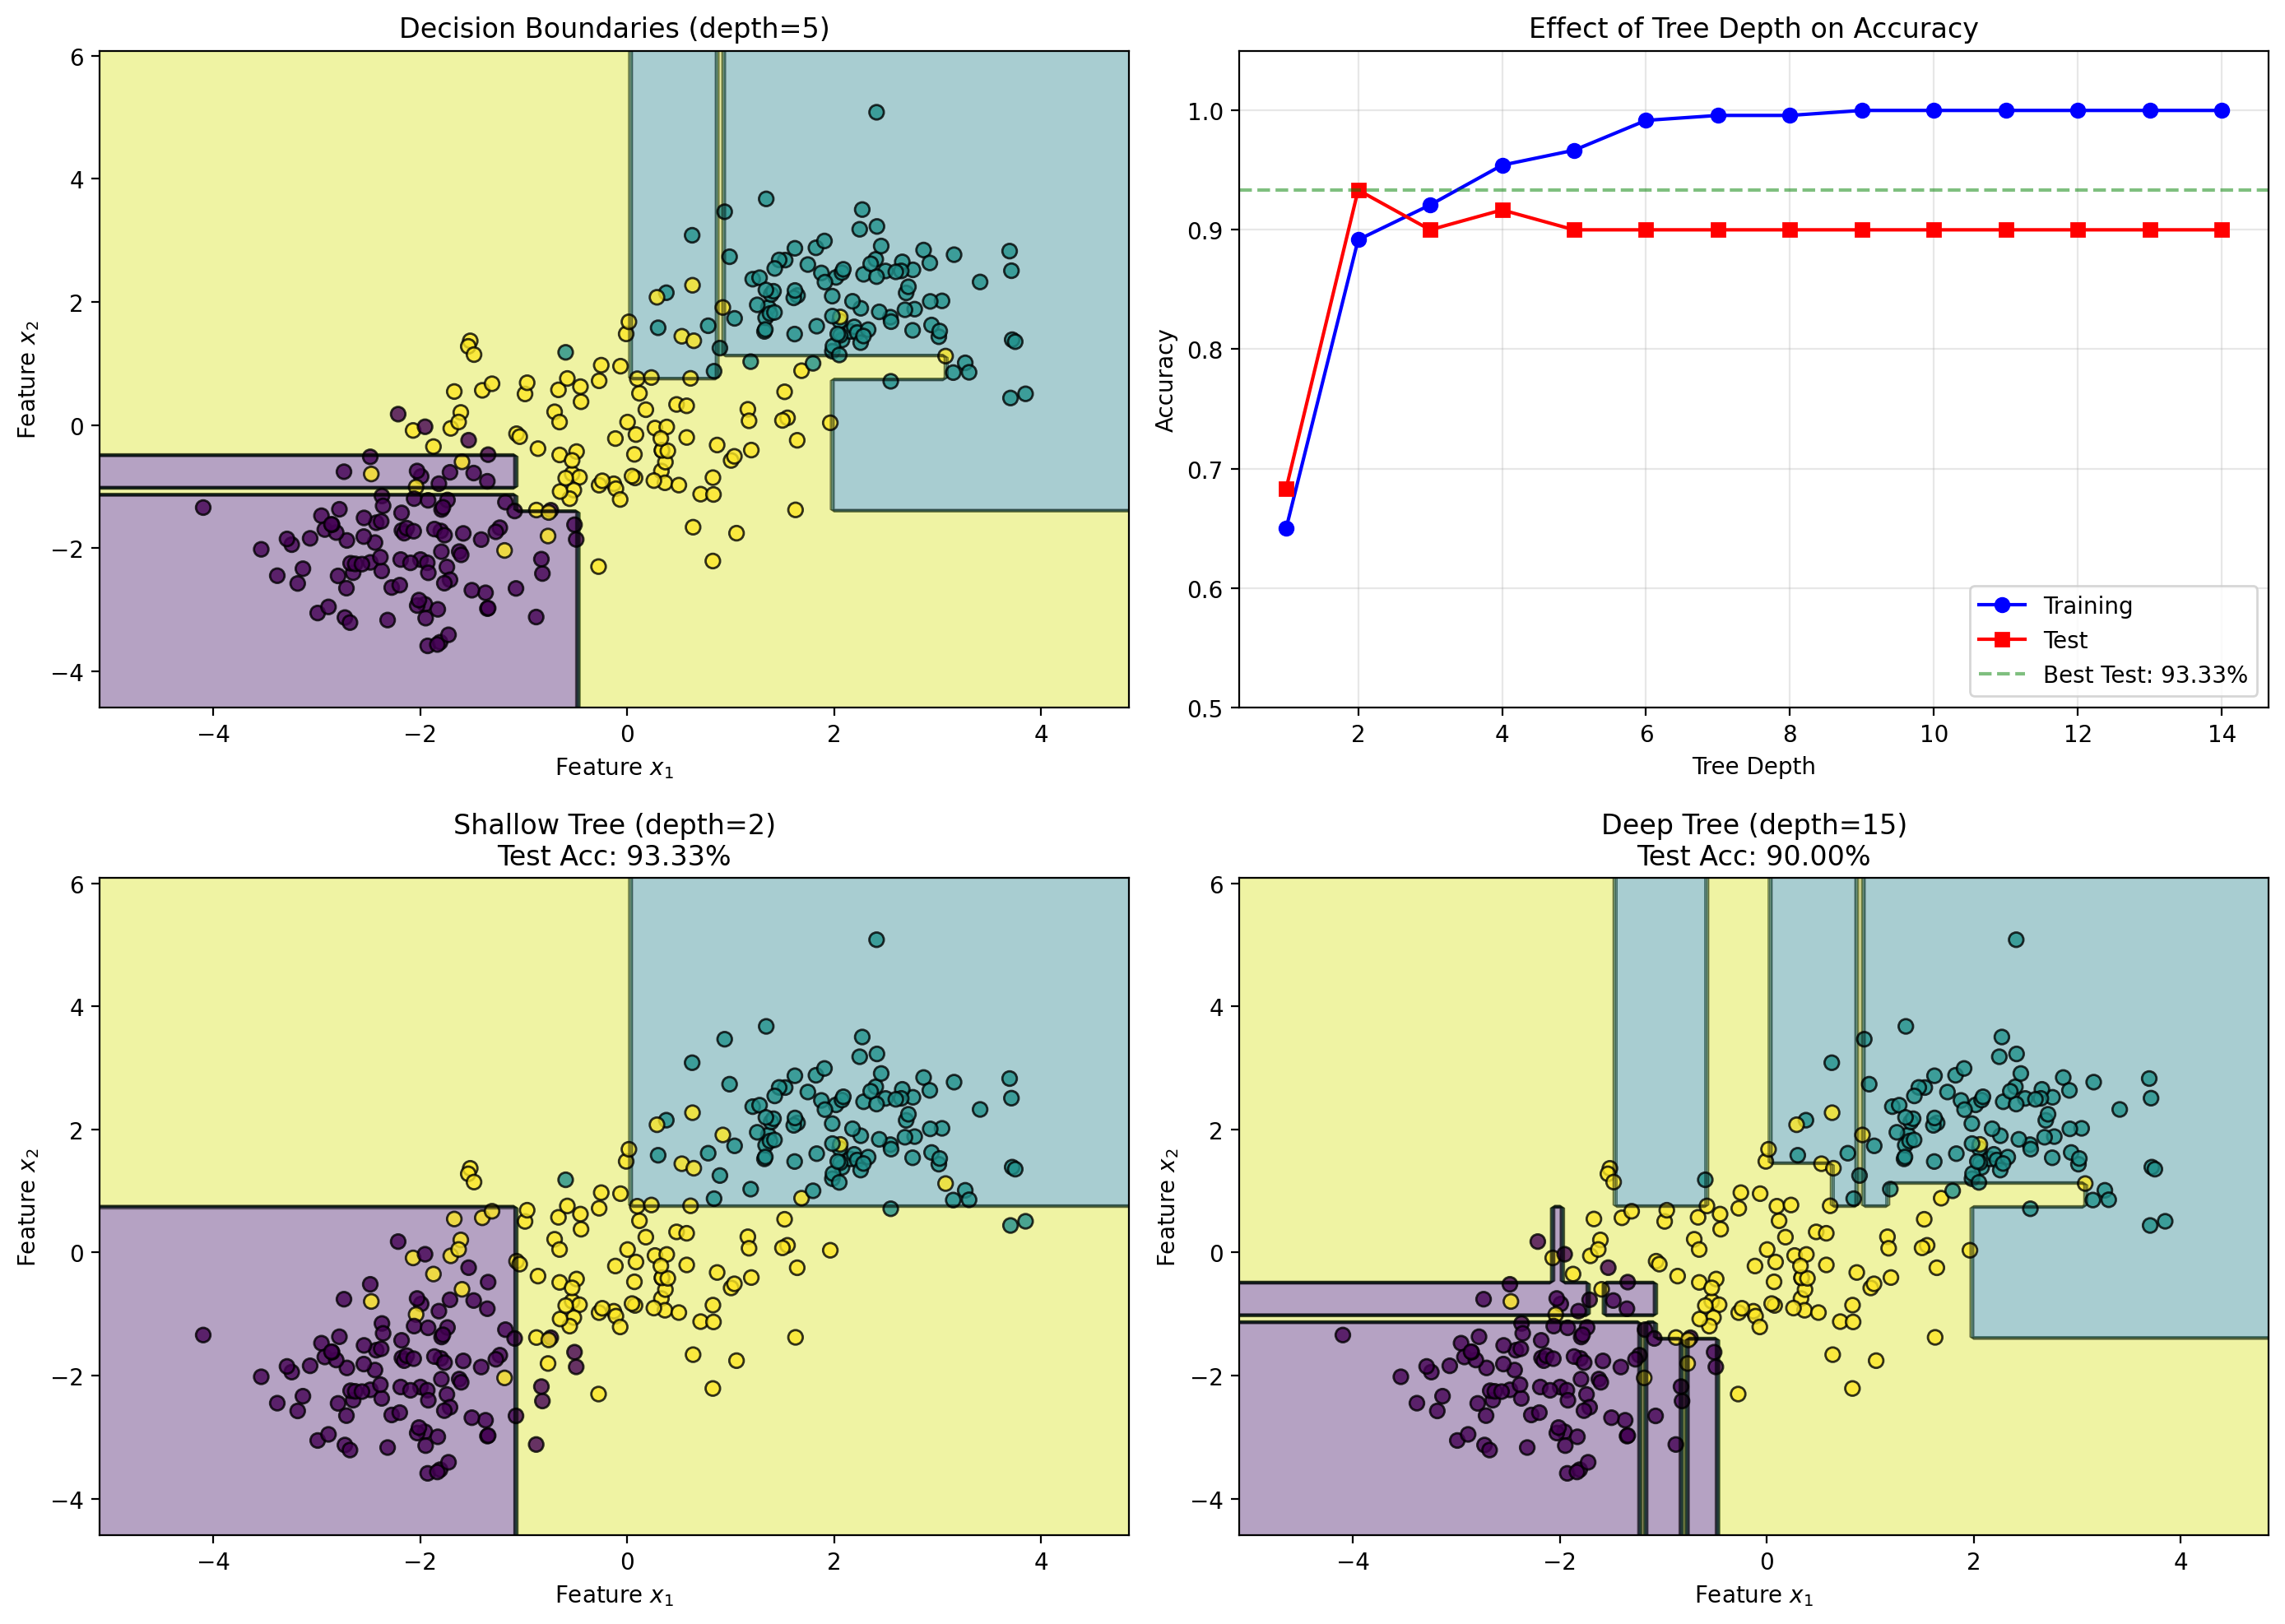


Figure saved to 'plot.png'


In [6]:
# Analyze effect of tree depth
depths = range(1, 15)
train_scores = []
test_scores = []

for depth in depths:
    tree_temp = DecisionTreeClassifier(max_depth=depth, min_samples_split=2)
    tree_temp.fit(X_train, y_train)
    train_scores.append(tree_temp.score(X_train, y_train))
    test_scores.append(tree_temp.score(X_test, y_test))

# Create comprehensive figure
fig = plt.figure(figsize=(14, 10))

# Plot 1: Decision boundaries
ax1 = fig.add_subplot(2, 2, 1)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax1.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
ax1.contour(xx, yy, Z, colors='k', linewidths=0.5, alpha=0.5)
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
                       edgecolors='black', s=40, alpha=0.8)
ax1.set_xlabel('Feature $x_1$', fontsize=10)
ax1.set_ylabel('Feature $x_2$', fontsize=10)
ax1.set_title('Decision Boundaries (depth=5)', fontsize=12)

# Plot 2: Depth vs Accuracy
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(depths, train_scores, 'b-o', label='Training', markersize=6)
ax2.plot(depths, test_scores, 'r-s', label='Test', markersize=6)
ax2.axhline(y=max(test_scores), color='g', linestyle='--', alpha=0.5, 
            label=f'Best Test: {max(test_scores):.2%}')
ax2.set_xlabel('Tree Depth', fontsize=10)
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.set_title('Effect of Tree Depth on Accuracy', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.5, 1.05])

# Plot 3: Shallow tree (underfitting)
ax3 = fig.add_subplot(2, 2, 3)
shallow_tree = DecisionTreeClassifier(max_depth=2, min_samples_split=2)
shallow_tree.fit(X_train, y_train)
Z_shallow = shallow_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax3.contourf(xx, yy, Z_shallow, alpha=0.4, cmap='viridis')
ax3.contour(xx, yy, Z_shallow, colors='k', linewidths=0.5, alpha=0.5)
ax3.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
           edgecolors='black', s=40, alpha=0.8)
shallow_test_acc = shallow_tree.score(X_test, y_test)
ax3.set_xlabel('Feature $x_1$', fontsize=10)
ax3.set_ylabel('Feature $x_2$', fontsize=10)
ax3.set_title(f'Shallow Tree (depth=2)\nTest Acc: {shallow_test_acc:.2%}', fontsize=12)

# Plot 4: Deep tree (overfitting)
ax4 = fig.add_subplot(2, 2, 4)
deep_tree = DecisionTreeClassifier(max_depth=15, min_samples_split=2)
deep_tree.fit(X_train, y_train)
Z_deep = deep_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax4.contourf(xx, yy, Z_deep, alpha=0.4, cmap='viridis')
ax4.contour(xx, yy, Z_deep, colors='k', linewidths=0.5, alpha=0.5)
ax4.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
           edgecolors='black', s=40, alpha=0.8)
deep_test_acc = deep_tree.score(X_test, y_test)
ax4.set_xlabel('Feature $x_1$', fontsize=10)
ax4.set_ylabel('Feature $x_2$', fontsize=10)
ax4.set_title(f'Deep Tree (depth=15)\nTest Acc: {deep_test_acc:.2%}', fontsize=12)

plt.tight_layout()
plt.savefig('decision_tree_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to 'plot.png'")

## Key Observations

### Characteristics of Decision Trees

1. **Axis-aligned boundaries**: Decision trees create rectangular decision regions aligned with feature axes, visible in the stepped boundaries.

2. **Interpretability**: Each prediction can be traced through a series of simple if-then rules.

3. **Bias-Variance Tradeoff**:
   - Shallow trees (high bias): Underfit the data, missing important patterns
   - Deep trees (high variance): Overfit to training noise, creating complex boundaries

### Mathematical Insights

The Gini impurity $G = 1 - \sum_k p_k^2$ provides computational efficiency over entropy while yielding similar splits in practice. For binary classification:

$$G = 2p(1-p)$$

reaching maximum at $p = 0.5$.

### Limitations

- Cannot capture diagonal or curved boundaries efficiently
- Sensitive to small changes in data (high variance)
- Greedy optimization may miss globally optimal splits

These limitations motivate ensemble methods like Random Forests and Gradient Boosting.

In [7]:
# Summary statistics
print("=" * 50)
print("DECISION TREE ANALYSIS SUMMARY")
print("=" * 50)
print(f"\nDataset: {len(y)} samples, {X.shape[1]} features, {len(np.unique(y))} classes")
print(f"Train/Test split: {len(y_train)}/{len(y_test)}")
print(f"\nOptimal Tree (depth=5):")
print(f"  Training Accuracy: {train_accuracy:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"\nDepth Analysis:")
print(f"  Best test accuracy: {max(test_scores):.4f} at depth {depths[np.argmax(test_scores)]}")
print(f"  Shallow tree (d=2): {shallow_test_acc:.4f}")
print(f"  Deep tree (d=15): {deep_test_acc:.4f}")

DECISION TREE ANALYSIS SUMMARY

Dataset: 300 samples, 2 features, 3 classes
Train/Test split: 240/60

Optimal Tree (depth=5):
  Training Accuracy: 0.9583
  Test Accuracy: 0.9000

Depth Analysis:
  Best test accuracy: 0.9333 at depth 2
  Shallow tree (d=2): 0.9333
  Deep tree (d=15): 0.9000
